# MAR33 Internal models approach: capital requirements calculation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sqlalchemy import create_engine

# 1. Configure connection
engine = create_engine('mysql+pymysql://root:@localhost:3306/frtb', echo=False)


# 2) 从数据库读取两张表：daily_pl 和 stress_period_report
#    stress_period_report is like["desk","start_date","end_date","min_rolling_pl"]
daily_pl = pd.read_sql_table(
    'daily_pl', 
    engine, 
    parse_dates=['DATE']
)
stress = pd.read_sql_table(
    'stress_period_report', 
    engine, 
    parse_dates=['start_date','end_date']
)

# 3) 把日期设置为 DataFrame 索引，并按日期排序
daily_pl = (
    daily_pl
    .set_index('DATE')
    .sort_index()
)

# 4) 定义一个 10 天 Expected Shortfall (ES) 函数
def ES_10d(pnl: pd.Series) -> float:
    """
    计算 10 天滚动 P&L 的 97.5% ES（Return positive value）
    """
    # 先算 10 天liquidity horizon滚动和
    roll10 = pnl.rolling(window=10).sum().dropna()
    # 找到 2.5% 分位
    cutoff = roll10.quantile(0.025)
    # 取所有 ≤ cutoff 的平均并取正
    return -roll10[roll10 <= cutoff].mean()

# 5) 从 daily_pl 的列名里提取所有 desk （去掉后缀 "_PL"）
desk_cols = [c for c in daily_pl.columns if c.endswith('_PL')]
desks = [c[:-3] for c in desk_cols]

# 6) 计算当前 IMA（最近 250 个交易日）
cur_IMA = {}
last250 = daily_pl.iloc[-250:]             # the latest 250 days
for desk in desks:
    col = desk + '_PL'
    cur_IMA[desk] = ES_10d(last250[col])

# 7) 计算 Enterprise Stress Period 对应的 IMA
ent = stress[stress['desk']=='ENTERPRISE'].iloc[0]
sp_IMA_enterprise = {}
for desk in desks:
    col = desk + '_PL'
    segment = daily_pl.loc[ent.start_date:ent.end_date, col]
    sp_IMA_enterprise[desk] = ES_10d(segment)

# 8) 计算每个 desk 自己的 Stress Period IMA，以及存字符串表示的日期范围
sp_IMA_desk = {}
sp_enterprise = {}
sp_desk = {}

# enterprise 字符串储存，后面会继续使用
ent_range_str = f"[{ent.start_date.date()}, {ent.end_date.date()}]"

for desk in desks:
    # 8.Enterprise stress period 的日期字符串
    sp_enterprise[desk] = ent_range_str

    # 8.本 desk 自己的 stress period
    r = stress[stress['desk']==desk].iloc[0]
    drange_str = f"[{r.start_date.date()}, {r.end_date.date()}]"
    sp_desk[desk] = drange_str

    # 8.计算这个 desk 在它对应 stress window 上的 ES
    col = desk + '_PL'
    seg = daily_pl.loc[r.start_date:r.end_date, col]
    sp_IMA_desk[desk] = ES_10d(seg)

# 9) 用 zip + from_dict 组合成最终的 DataFrame
keys   = desks
values = zip(
    [cur_IMA[d]            for d in keys],  # IMA_C
    [sp_IMA_enterprise[d]  for d in keys],  # IMA_ESP
    [sp_IMA_desk[d]        for d in keys],  # IMA_DSP
    [sp_enterprise[d]      for d in keys],  # ESP （字符串形式）
    [sp_desk[d]            for d in keys],  # DSP （字符串形式）
)

final_dict = dict(zip(keys, values))

Final_pd = (
    pd.DataFrame
      .from_dict(final_dict, orient='index',
                 columns=['IMA_C','IMA_ESP','IMA_DSP','ESP','DSP'])
      .reset_index()
      .rename(columns={'index':'desk'})
)




In [3]:
sp_desk

{'DESK3_A': '[2007-05-10, 2008-04-25]',
 'DESK3_B': '[2007-05-11, 2008-04-28]',
 'DESK3_C': '[2007-05-10, 2008-04-25]',
 'DESK3_D': '[2007-12-10, 2008-11-25]',
 'DESK3_E': '[2007-12-10, 2008-11-25]',
 'DESK3_F': '[2009-05-28, 2010-05-14]',
 'DESK3_G': '[2009-01-21, 2010-01-07]',
 'DESK3_H': '[2007-10-23, 2008-10-08]',
 'DESK3_I': '[2009-01-21, 2010-01-07]',
 'DESK3_J': '[2008-08-06, 2009-07-23]',
 'DESK3_K': '[2008-08-06, 2009-07-23]',
 'DESK3_L': '[2007-05-11, 2008-04-28]',
 'DESK3_M': '[2007-10-23, 2008-10-08]',
 'DESK3_N': '[2008-10-09, 2009-09-25]'}

In [4]:
Final_pd

,desk,IMA_C,IMA_ESP,IMA_DSP,ESP,DSP
0,DESK3_A,180588.900319,389256.323589,661758.076796,"[2007-12-10, 2008-11-25]","[2007-05-10, 2008-04-25]"
1,DESK3_B,227862.421334,372823.074664,662555.815170,"[2007-12-10, 2008-11-25]","[2007-05-11, 2008-04-28]"
2,DESK3_C,178164.299213,385226.822911,656361.110380,"[2007-12-10, 2008-11-25]","[2007-05-10, 2008-04-25]"
3,DESK3_D,59780.655129,170713.360314,170713.360314,"[2007-12-10, 2008-11-25]","[2007-12-10, 2008-11-25]"
4,DESK3_E,60858.885886,168136.128543,168136.128543,"[2007-12-10, 2008-11-25]","[2007-12-10, 2008-11-25]"
5,DESK3_F,75453.853627,174140.048543,191338.544467,"[2007-12-10, 2008-11-25]","[2009-05-28, 2010-05-14]"
6,DESK3_G,1305.860683,2976.478969,3745.429363,"[2007-12-10, 2008-11-25]","[2009-01-21, 2010-01-07]"
7,DESK3_H,957.773429,7261.975339,7069.216481,"[2007-12-10, 2008-11-25]","[2007-10-23, 2008-10-08]"
8,DESK3_I,1272.281398,3178.099453,4193.763777,"[2007-12-10, 2008-11-25]","[2009-01-21, 2010-01-07]"
9,DESK3_J,1563.917236,3156.706347,3613.211761,"[2007-12-10, 2008-11-25]","[2008-08-06, 2009-07-23]"


In [5]:
stress

,desk,start_date,end_date,min_rolling_pl
0,DESK3_A,2007-05-10,2008-04-25,-3160256.33
1,DESK3_B,2007-05-11,2008-04-28,-3134878.38
2,DESK3_C,2007-05-10,2008-04-25,-3129657.10
3,DESK3_D,2007-12-10,2008-11-25,-218861.25
4,DESK3_E,2007-12-10,2008-11-25,-224710.95
5,DESK3_F,2009-05-28,2010-05-14,-275116.40
6,DESK3_G,2009-01-21,2010-01-07,-6056.05
7,DESK3_H,2007-10-23,2008-10-08,-12830.18
8,DESK3_I,2009-01-21,2010-01-07,-7077.85
9,DESK3_J,2008-08-06,2009-07-23,-6875.28


In [6]:
daily_pl.head()

,DESK3_A_PL,DESK3_B_PL,DESK3_C_PL,DESK3_D_PL,DESK3_E_PL,DESK3_F_PL,DESK3_G_PL,DESK3_H_PL,DESK3_I_PL,DESK3_J_PL,DESK3_K_PL,DESK3_L_PL,DESK3_M_PL,DESK3_N_PL
DATE,,,,,,,,,,,,,,
2006-09-04,34988.977140,-34963.251002,35087.194144,-2663.2972,-1555.9546,-6875.7043,-120.225619,-65.641726,-168.920365,95.066495,887.02707,-39398.933190,-65.621301,65.621301
2006-09-05,21050.765750,-21863.937988,21609.185116,22149.9349,4117.9578,44863.1005,721.606905,129.830743,726.046026,670.268569,502.93617,-24073.960063,129.847760,-129.847760
2006-09-06,899.959980,54.368320,-38.490690,-21069.7223,626.7382,-38648.7913,-594.088761,-68.766928,-633.289369,-400.499563,297.86990,-33.587797,-68.779667,68.779667
2006-09-07,8010.930900,-7723.347460,7414.549550,-619.5219,-9338.1026,-8835.9087,-171.930164,3.538691,-173.777415,-159.180376,-115.38925,-8305.900557,3.532532,-3.532532
2006-09-08,47041.517421,-47153.818050,47166.459760,-2098.9947,946.9079,13616.6932,295.989980,37.912010,297.476495,296.680383,294.29202,-52820.688633,37.921007,-37.921007


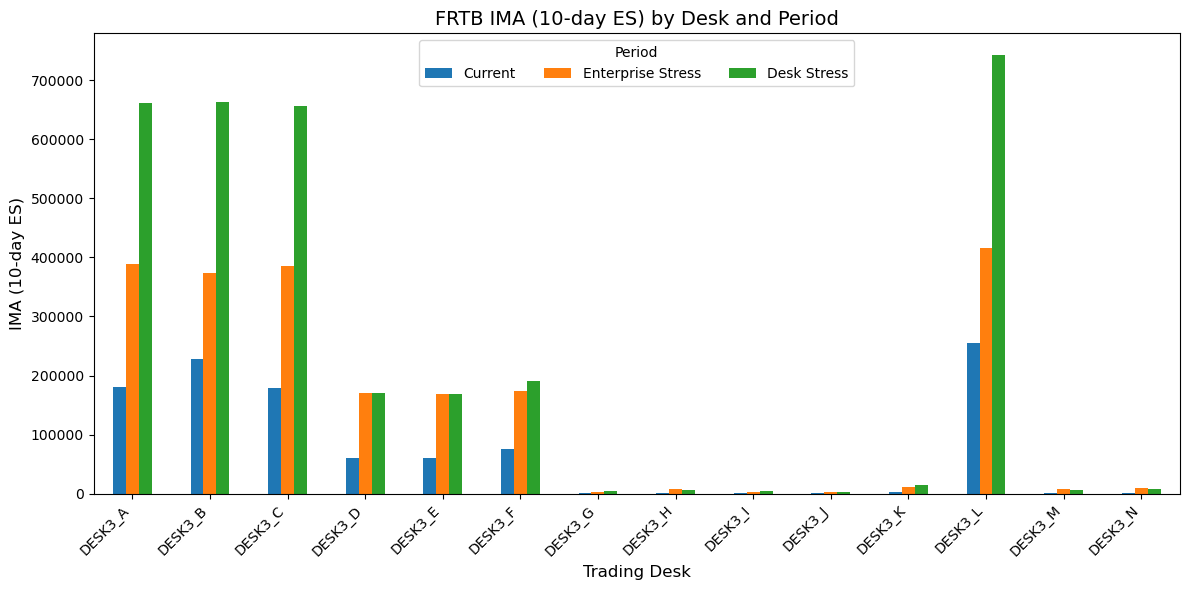

In [7]:
# Pivot to desks × [IMA_C, IMA_ESP, IMA_DSP]
# 1) Recreate the pivot by each desk
plot_df = Final_pd.set_index('desk')[['IMA_C', 'IMA_ESP', 'IMA_DSP']]

# 2) Draw bars
fig, ax = plt.subplots(figsize=(12, 6))
plot_df.plot.bar(ax=ax)

# 3) Labels and title
ax.set_title('FRTB IMA (10‑day ES) by Desk and Period', fontsize=14)
ax.set_xlabel('Trading Desk', fontsize=12)
ax.set_ylabel('IMA (10‑day ES)', fontsize=12)

# 4) Legend at top-middle
ax.legend(
    ['Current', 'Enterprise Stress', 'Desk Stress'],
    title='Period',
    loc='upper center',
    bbox_to_anchor=(0.5, 1.0),
    ncol=3
)

# 5) formatting
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



In [8]:
PL_pd = daily_pl.copy()

In [9]:
PL_pd

,DESK3_A_PL,DESK3_B_PL,DESK3_C_PL,DESK3_D_PL,DESK3_E_PL,DESK3_F_PL,DESK3_G_PL,DESK3_H_PL,DESK3_I_PL,DESK3_J_PL,DESK3_K_PL,DESK3_L_PL,DESK3_M_PL,DESK3_N_PL
DATE,,,,,,,,,,,,,,
2006-09-04,34988.977140,-34963.251002,35087.194144,-2663.2972,-1555.9546,-6875.7043,-120.225619,-65.641726,-168.920365,95.066495,887.02707,-39398.933190,-65.621301,65.621301
2006-09-05,21050.765750,-21863.937988,21609.185116,22149.9349,4117.9578,44863.1005,721.606905,129.830743,726.046026,670.268569,502.93617,-24073.960063,129.847760,-129.847760
2006-09-06,899.959980,54.368320,-38.490690,-21069.7223,626.7382,-38648.7913,-594.088761,-68.766928,-633.289369,-400.499563,297.86990,-33.587797,-68.779667,68.779667
2006-09-07,8010.930900,-7723.347460,7414.549550,-619.5219,-9338.1026,-8835.9087,-171.930164,3.538691,-173.777415,-159.180376,-115.38925,-8305.900557,3.532532,-3.532532
2006-09-08,47041.517421,-47153.818050,47166.459760,-2098.9947,946.9079,13616.6932,295.989980,37.912010,297.476495,296.680383,294.29202,-52820.688633,37.921007,-37.921007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08-25,-62096.991490,61184.989910,-61341.259805,15969.2289,15712.1695,7604.5624,80.764987,-66.797003,68.434963,114.513101,252.74752,68674.475430,-66.784391,66.784391
2016-08-26,48771.124380,-48167.077340,48644.037555,16944.4419,16079.2692,20435.7272,355.463447,200.281121,390.125204,182.494633,-440.39709,-54296.072876,200.339326,-200.339326
2016-08-29,14193.721030,-13628.060270,12581.942090,-62273.9080,-60869.5880,-75333.1616,-1268.605322,-1281.424441,-1249.422635,-1272.645249,-1342.31309,-15534.456274,-1281.544173,1281.544173


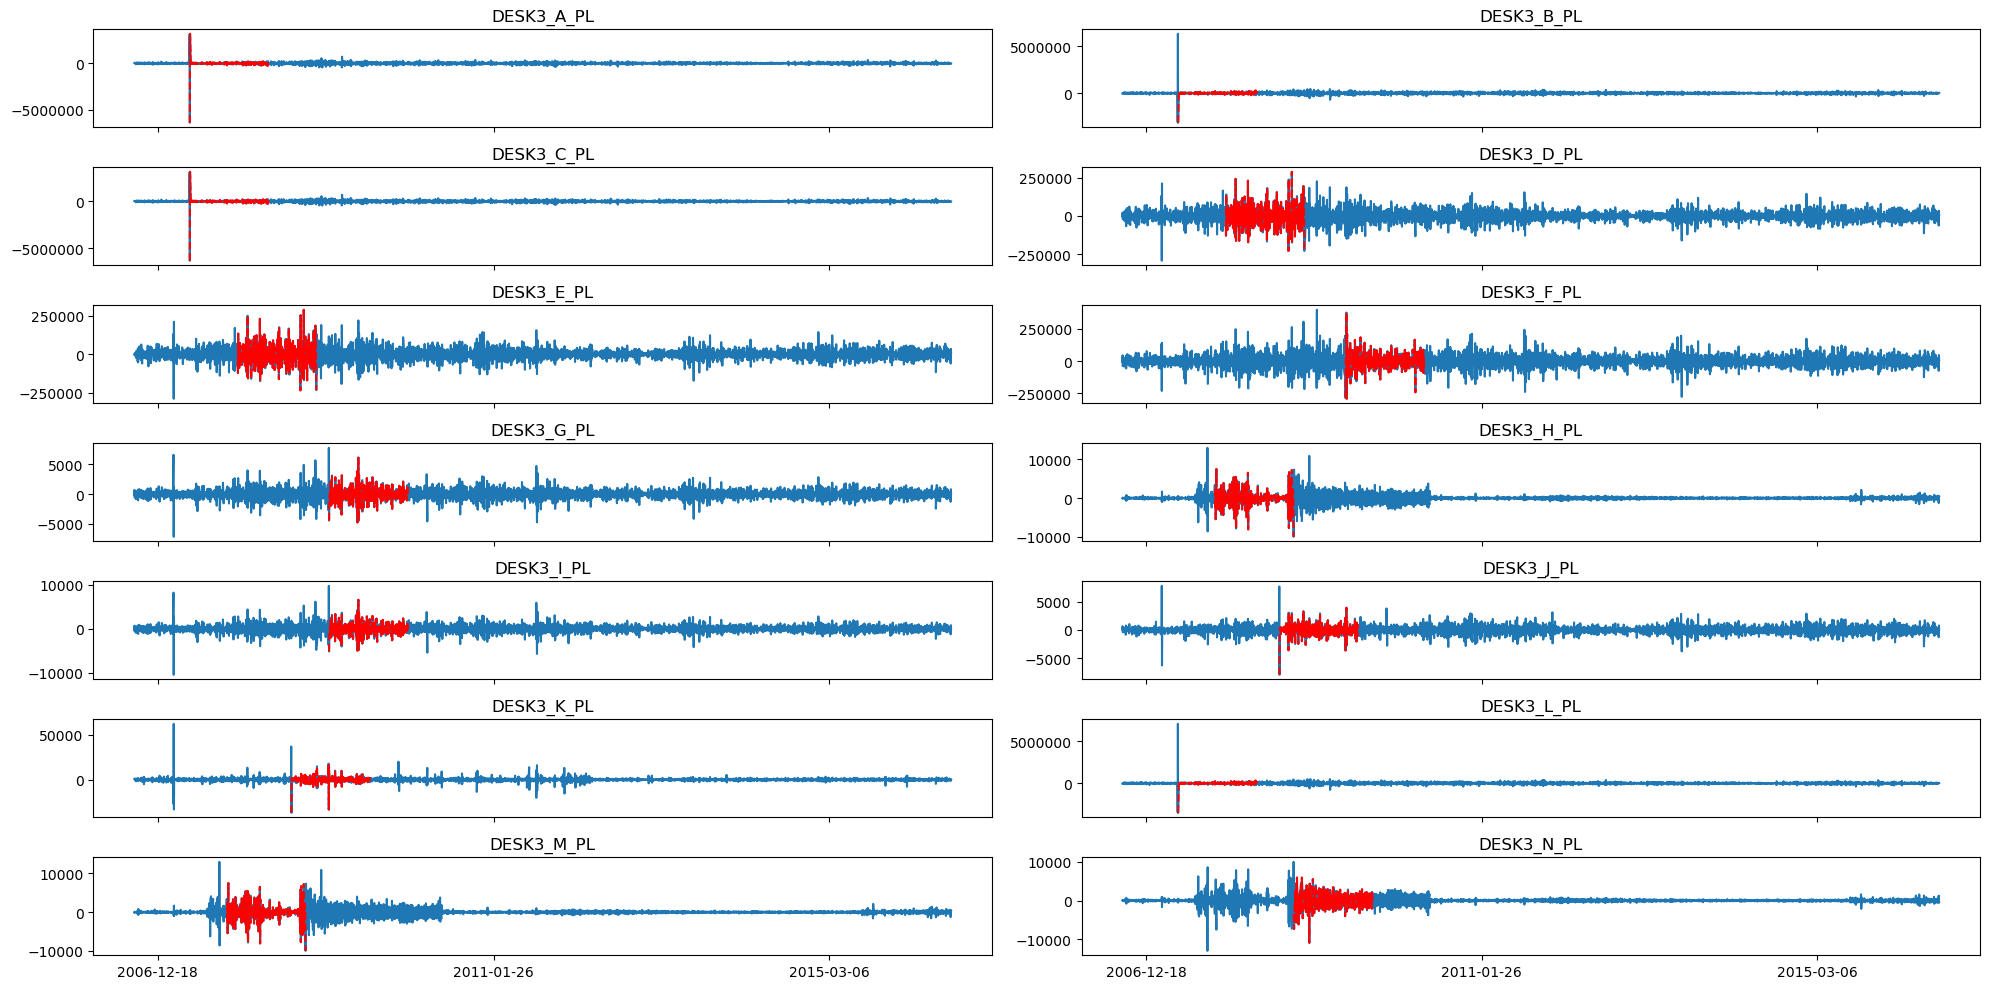

In [11]:
#1.transform the DATE into datetime
PL_pd.index = pd.to_datetime(PL_pd.index)
sp_desk = dict(zip(
    stress['desk'],
    zip(stress['start_date'], stress['end_date'])
))
#2.align the sp_ds key to PL.pd.columns ends with_PL
sp_ds = {f"{k}_PL": v for k, v in sp_desk.items()}
#3.plot
cols = PL_pd.columns.tolist()

fig, axs = plt.subplots((len(cols)+1)//2, 2, figsize=(20,10), sharex=True)
axs = axs.ravel()

for i, c in enumerate(cols):
    ax = axs[i]
    ax.plot(PL_pd[c])
    s, e = sp_ds[c]
    ax.plot(PL_pd.loc[s:e, c], 'r--')
    ax.set_title(c)
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))

    # 关闭 y 轴科学计数法  
    ax.ticklabel_format(style='plain', axis='y')

# 关掉多余子图
for ax in axs[len(cols):]:
    ax.axis('off')

plt.tight_layout()
plt.savefig('StressPeriodDesk.png', dpi=300)
plt.show()
